# Crypto Portfolio Selection 

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import polars as pl
import polars.selectors as cs

# Load data

In [2]:
import pandas as pd
import yfinance as yf

data: pd.DataFrame = yf.download("BTC-USD ETH-USD", start="2018-01-01", end="2024-01-01")["Close"].dropna()

[*********************100%***********************]  2 of 2 completed


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

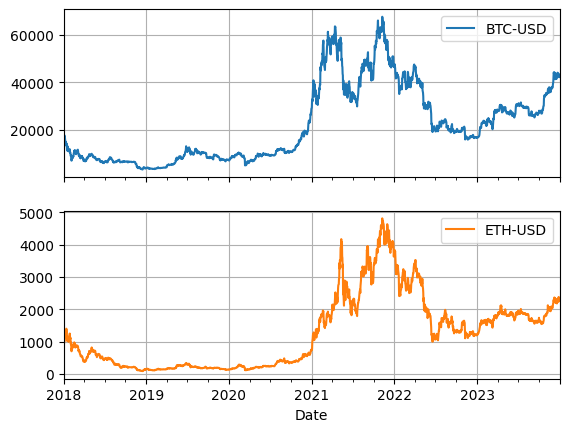

In [3]:
data.plot(grid=True, subplots=True)

In [4]:
pl.from_dataframe(data.reset_index()) 

Date,BTC-USD,ETH-USD
"datetime[ns, UTC]",f64,f64
2018-01-01 00:00:00 UTC,13657.200195,772.640991
2018-01-02 00:00:00 UTC,14982.099609,884.44397
2018-01-03 00:00:00 UTC,15201.0,962.719971
2018-01-04 00:00:00 UTC,15599.200195,980.921997
2018-01-05 00:00:00 UTC,17429.5,997.719971
…,…,…
2023-12-27 00:00:00 UTC,43442.855469,2378.73999
2023-12-28 00:00:00 UTC,42627.855469,2347.566162
2023-12-29 00:00:00 UTC,42099.402344,2300.690674


In [5]:
df_returns = (
    pl.from_dataframe(data.reset_index()) 
    .select(
        cs.datetime(),
        pl.col("BTC-USD").pct_change(),
        pl.col("ETH-USD").pct_change(),
    )
    .drop_nulls()
)
df_returns

Date,BTC-USD,ETH-USD
"datetime[ns, UTC]",f64,f64
2018-01-02 00:00:00 UTC,0.097011,0.144702
2018-01-03 00:00:00 UTC,0.014611,0.088503
2018-01-04 00:00:00 UTC,0.026196,0.018907
2018-01-05 00:00:00 UTC,0.117333,0.017125
2018-01-06 00:00:00 UTC,0.005594,0.044061
…,…,…
2023-12-27 00:00:00 UTC,0.021694,0.065999
2023-12-28 00:00:00 UTC,-0.01876,-0.013105
2023-12-29 00:00:00 UTC,-0.012397,-0.019968


# Offline portfolio

In [6]:
from potato.benchmark import best_kelly_portfolio


returns = jnp.array(
    df_returns.to_numpy()[:, 1:]
)

long_only = best_kelly_portfolio(returns)
long_short = best_kelly_portfolio(returns, short_selling=True)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [7]:
df_portfolio_return = (
    df_returns
    .with_columns(
        CRP = pl.col(df_returns.columns[1]) * (0.5) + pl.col(df_returns.columns[2]) * 0.5,
        kelly_long_only = pl.col(df_returns.columns[1]) * long_only[0] + pl.col(df_returns.columns[2]) * long_only[1],
        kelly_long_short = pl.col(df_returns.columns[1]) * long_short[0] + pl.col(df_returns.columns[2]) * long_short[1],
    )
)

optimal fixed porfolio

In [8]:
long_short

Array([0.35150072, 0.49165952], dtype=float32)

# Online portfolio

## Long/short portfolio

In [9]:
import optax
from potato.optimizer import egd
from potato.transform import fix_share
from potato.loss import kelly_loss

eta = 1e-1
optimizer = egd(learning_rate=1e-1)
opt_state = optimizer.init(returns[0])

In [10]:
@jax.jit
def step(params, rs, state):
    loss, grad = jax.value_and_grad(kelly_loss)(params, rs)
    updates, state = optimizer.update(grad, state, params)
    params = optax.apply_updates(params, updates)
    params = fix_share(params, eta)
    return params, state, loss

params = jnp.array([0.5, 0.5])
weights = []
for i in range(returns.shape[0]):
    weights.append(params)
    params, opt_state, loss = step(params, returns[i], opt_state)
    # print(f"Step {i}: loss={loss}, params={params}")

weights = np.array(weights)

TypeError: Shapes must be 1D sequences of concrete values of integer type, got Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=1/0)>.
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
The error occurred while tracing the function step at /tmp/ipykernel_114037/2800493428.py:1 for jit. This concrete value was not available in Python because it depends on the values of the arguments params and rs.
The error occurred while tracing the function step at /tmp/ipykernel_114037/2800493428.py:1 for jit. This concrete value was not available in Python because it depends on the values of the arguments params and rs.

In [11]:
df_portfolio_return = df_portfolio_return.with_columns(
    PGD=pl.Series(values=np.sum(weights * np.array(returns), axis=-1))
)

In [ ]:
df_portfolio_return

In [ ]:
df_sharpes = (
    df_portfolio_return
    .select(cs.numeric().mean() / cs.numeric().std() * jnp.sqrt(252))
)
df_sharpes

In [ ]:
df_portfolio_return = (
    df_portfolio_return
    .select(cs.datetime(), cs.numeric().add(1).cum_prod().sub(1))
)

import matplotlib.pyplot as plt

plt.plot(df_returns["Date"], df_portfolio_return["PGD"], label="PGD")
plt.plot(df_returns["Date"], df_portfolio_return["CRP"], label="CRP")
plt.plot(df_returns["Date"], df_portfolio_return["kelly_long_only"], label="kelly_long_only", linestyle="--", alpha=0.4)
plt.plot(df_returns["Date"], df_portfolio_return["kelly_long_short"], label="kelly_long_short", linestyle="--", alpha=0.4)
# plt.plot(df_returns["Date"], df_portfolio_return["BTC-USD"], label="BTC-USD", linestyle="--", alpha=0.5)
# plt.plot(df_returns["Date"], df_portfolio_return["ETH-USD"], label="ETH-USD", linestyle="--", alpha=0.5)
plt.legend()
plt.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df_returns["Date"], weights[:, 0], label="BTC-USD")
plt.plot(df_returns["Date"], weights[:, 1], label="ETH-USD")
plt.hlines(0, df_returns["Date"][0], df_returns["Date"][-1], linestyles="--", colors="red")
plt.legend()
plt.grid()
plt.show()